In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Basics with Pennylane

In [6]:
dev1 =  qml.device("default.qubit", wires=1)
@qml.qnode(dev1, interface="autograd")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))
print(circuit([np.pi/4, np.pi/4]))

0.49999999999999994


In [12]:
dcircuit = qml.grad(circuit, argnum=0)
print(dcircuit([np.pi/2, np.pi/2]))

[array(0.), array(0.)]


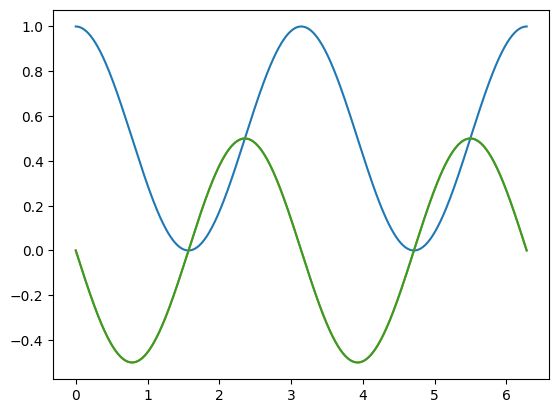

In [16]:
x = np.linspace(0,2*np.pi, 1000)
plt.plot(x, circuit([x,x]))
plt.plot(x, [dcircuit([i,i]) for i in x])

In [ ]:
@qml.qnode(dev1, interface="autograd")
def circuit2(phi1, phi2):
    qml.RX(phi1, wires=0)
    qml.RZ(phi2, wires=0)
    return qml.expval(qml.PauliZ(0))
dcircuit = qml.grad(circuit2, argnum=[0, 1])
#argnum defines after which param you build the gradient in respect to

In [17]:
init_params = np.array([0.011, 0.012], requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.4)
steps = 100
params = init_params
for i in range(steps):
    params = opt.step(circuit, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, circuit(params)))
print("Optimized rotation angles: {}".format(params))

Cost after step     5:  0.9961778
Cost after step    10:  0.8974944
Cost after step    15:  0.1440490
Cost after step    20: -0.1536720
Cost after step    25: -0.9152496
Cost after step    30: -0.9994046
Cost after step    35: -0.9999964
Cost after step    40: -1.0000000
Cost after step    45: -1.0000000
Cost after step    50: -1.0000000
Cost after step    55: -1.0000000
Cost after step    60: -1.0000000
Cost after step    65: -1.0000000
Cost after step    70: -1.0000000
Cost after step    75: -1.0000000
Cost after step    80: -1.0000000
Cost after step    85: -1.0000000
Cost after step    90: -1.0000000
Cost after step    95: -1.0000000
Cost after step   100: -1.0000000
Optimized rotation angles: [7.15266381e-18 3.14159265e+00]


In [19]:
np.random.seed(42)
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, diff_method="parameter-shift", interface="autograd")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")

    qml.RX(params[3], wires=0)
    qml.RY(params[4], wires=1)
    qml.RZ(params[5], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation value: -0.11971365706871567


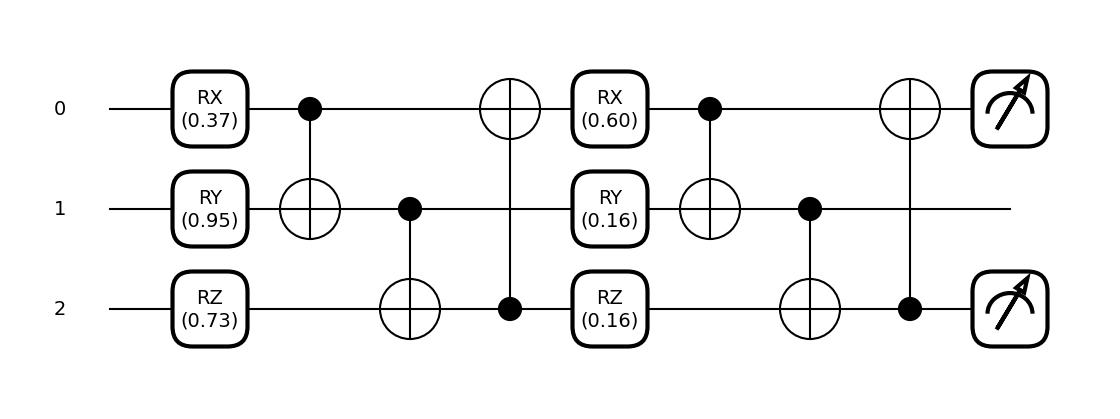

In [20]:
params = np.random.random([6], requires_grad=True)

print("Parameters:", params)
print("Expectation value:", circuit(params))
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [21]:
def parameter_shift_term(qnode, params, i):
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted) # backward evaluation

    return 0.5 * (forward - backward)

print(parameter_shift_term(circuit, params, 0))
grad_function = qml.grad(circuit)
print(grad_function(params)[0])
#--------------------------------
def parameter_shift(qnode, params):
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode, params, i)

    return gradients

print(parameter_shift(circuit, params))
print(qml.gradients.param_shift(circuit)(params))

-0.06518877224958125
-0.06518877224958124
[-6.51887722e-02 -2.72891905e-02 -1.38777878e-17 -9.33934621e-02
 -7.61067572e-01  1.38777878e-17]
[-6.51887722e-02 -2.72891905e-02 -1.38777878e-17 -9.33934621e-02
 -7.61067572e-01  1.38777878e-17]


In [22]:
dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev, diff_method="backprop", interface="autograd")
def circuit(params):
    qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

# initialize circuit parameters
param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=15)
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
print(circuit(params))

import timeit
reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num
print(f"Forward pass (best of {reps}): {forward_time} sec per loop")
times = timeit.repeat("qml.grad(circuit)(params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num
print(f"Backward pass (best of {reps}): {backward_time} sec per loop")

0.8947771876917631
Forward pass (best of 3): 0.1055732699984219 sec per loop
Backward pass (best of 3): 0.31549014000047465 sec per loop


# Machine Learning with Keras

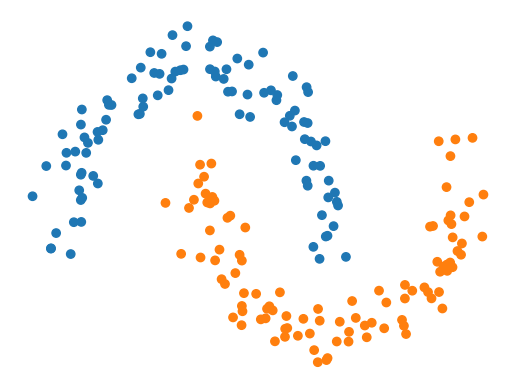

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

tf.keras.backend.set_floatx('float64')

layer_1 = tf.keras.layers.Dense(2)
layer_2 = tf.keras.layers.Dense(2, activation="softmax")

model = tf.keras.Sequential([layer_1, layer_2])
model.compile(loss="mae")



# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)  # one-hot encoded labels

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [24]:
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

In [33]:
# re-define the layers
clayer_1 = tf.keras.layers.Dense(4)
qlayer_1 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
qlayer_2 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
clayer_2 = tf.keras.layers.Dense(2, activation="softmax")

# construct the model
inputs = tf.keras.Input(shape=(2,))
x = clayer_1(inputs)
x_1, x_2 = tf.split(x, 2, axis=1)
x_1 = qlayer_1(x_1)
x_2 = qlayer_2(x_2)
x = tf.concat([x_1, x_2], axis=1)
outputs = clayer_2(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [26]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model.compile(opt, loss="mae", metrics=["accuracy"])

fitting = model.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25, verbose=2)

Epoch 1/6
30/30 - 126s - loss: 0.3919 - accuracy: 0.7867 - val_loss: 0.2998 - val_accuracy: 0.8200 - 126s/epoch - 4s/step
Epoch 2/6
30/30 - 108s - loss: 0.2725 - accuracy: 0.8333 - val_loss: 0.2343 - val_accuracy: 0.8400 - 108s/epoch - 4s/step
Epoch 3/6
30/30 - 84s - loss: 0.2116 - accuracy: 0.8533 - val_loss: 0.2019 - val_accuracy: 0.8200 - 84s/epoch - 3s/step
Epoch 4/6
30/30 - 77s - loss: 0.1849 - accuracy: 0.8400 - val_loss: 0.1853 - val_accuracy: 0.8400 - 77s/epoch - 3s/step
Epoch 5/6
30/30 - 78s - loss: 0.1720 - accuracy: 0.8667 - val_loss: 0.1776 - val_accuracy: 0.8600 - 78s/epoch - 3s/step
Epoch 6/6
30/30 - 81s - loss: 0.1563 - accuracy: 0.8667 - val_loss: 0.2127 - val_accuracy: 0.8400 - 81s/epoch - 3s/step


# Optimizing noisy circuits with Cirq

In [8]:
from pennylane import numpy as np
dev = qml.device("cirq.mixedsimulator", wires=2, shots=1000)
from pennylane_cirq import ops as cirq_ops

tf.keras.backend.set_floatx('float64')

p_noise = 0.15
n_qubits = 2
dev = qml.device("cirq.mixedsimulator", wires=n_qubits, shots=1000)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    cirq_ops.BitFlip(p_noise, wires=0)
    cirq_ops.AmplitudeDamp(p_noise, wires=1)
    # AmplitudeDamp
    # BitFlip
    # Depolarize
    # Operation
    # PhaseDamp
    # PhaseFlip
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
clayer_1 = tf.keras.layers.Dense(2)
clayer_2 = tf.keras.layers.Dense(2, activation="softmax")

model = tf.keras.models.Sequential([clayer_1, qlayer, clayer_2])
opt = tf.keras.optimizers.SGD(learning_rate=0.2)

model.compile(opt, loss="mae", metrics=["accuracy"])
fitting = model.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25, verbose=2)

#Possible Noise Options
available_ops = [op for op in dir(cirq_ops) if not op.startswith("_")]
print("\n".join(available_ops))

Epoch 1/6
30/30 - 91s - loss: 0.3661 - accuracy: 0.7200 - val_loss: 0.2735 - val_accuracy: 0.8000 - 91s/epoch - 3s/step
Epoch 2/6
30/30 - 72s - loss: 0.2548 - accuracy: 0.8333 - val_loss: 0.2260 - val_accuracy: 0.8400 - 72s/epoch - 2s/step
Epoch 3/6
30/30 - 72s - loss: 0.2083 - accuracy: 0.8400 - val_loss: 0.2011 - val_accuracy: 0.8200 - 72s/epoch - 2s/step
Epoch 4/6
30/30 - 79s - loss: 0.1872 - accuracy: 0.8667 - val_loss: 0.1855 - val_accuracy: 0.8600 - 79s/epoch - 3s/step
Epoch 5/6
30/30 - 72s - loss: 0.1714 - accuracy: 0.8667 - val_loss: 0.1763 - val_accuracy: 0.8600 - 72s/epoch - 2s/step
Epoch 6/6
30/30 - 74s - loss: 0.1578 - accuracy: 0.8667 - val_loss: 0.1884 - val_accuracy: 0.8200 - 74s/epoch - 2s/step
AmplitudeDamp
BitFlip
Depolarize
Operation
PhaseDamp
PhaseFlip
